# 04 bis - Clustering with BRUTAL approach

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import os
import matplotlib.animation as animation

from models.BRUTAL_X_RCC import XRCC#, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
from IPython.display import display

The BRUTAL approach involves providing a set of breakpoint dates to be used in the computation of the loss. The number of possible combinations of breakpoints, given a set of dates and a number of seasons, can be calculated using the binomial coefficient:

$$\binom{n}{k} = \frac{n!}{k!(n-k)!}$$

where:

- $n$ is the number of dates, and
- $k$ is the number of seasons.

In [13]:
# -- FREE PARAMETERS
n_seasons   = 3
n_days = list(np.arange(0,365,50))

learning_rate   = 5
min_len         = 10
mode            = 'single'
starting_bp     = [50, 330]

overwrite_results = False

In [14]:
# DA togliere solo per salvare il file
n_iters = 10

# Geopackages with boundaries
country_boundary_file   = '../data/preprocessed/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/preprocessed/external/GADM41_WORLD_clip.gpkg' 
hkkh_boundary_file      = '../data/preprocessed/external/HKKH.gpkg'

# Path for results
results_path_file   = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.nc'
results_path_image  = f'../data/results/images/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.png'

if os.path.exists(results_path_file) and overwrite_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not overwrite_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file)
hkkh_boundary       = gpd.read_file(hkkh_boundary_file)

In [15]:
if not os.path.exists(results_path_file) or overwrite_results:

    dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load()
    dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load()
    dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load()
    dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load()

    dataset_tp['time'] = dataset_t2m['time']
    dataset_u100['time'] = dataset_t2m['time']
    dataset_v100['time'] = dataset_t2m['time']

    datasets = [dataset_tp, dataset_t2m, dataset_u100, dataset_v100] 

    clustering_params = {
        'n_days' : n_days,
        'n_seas': n_seasons,
        'learning_rate': learning_rate,
        'min_len': min_len,
        'mode': mode,
        'starting_bp': starting_bp,
    }

    breakpoints, error_history_da, silhouette_scores_da = XRCC(datasets, **clustering_params)

else:
    result = xr.open_dataset(results_path_file).__xarray_dataarray_variable__

56it [00:00, 669.33it/s]
56it [00:00, 728.00it/s]
56it [00:00, 711.56it/s]
56it [00:00, 741.90it/s]
56it [00:00, 745.35it/s]
56it [00:00, 750.79it/s]
56it [00:00, 749.63it/s]
56it [00:00, 742.93it/s]
56it [00:00, 735.11it/s]
56it [00:00, 749.37it/s]
56it [00:00, 749.58it/s]
56it [00:00, 598.24it/s]
56it [00:00, 737.14it/s]
56it [00:00, 745.63it/s]
56it [00:00, 638.16it/s]
56it [00:00, 745.23it/s]
56it [00:00, 746.29it/s]
56it [00:00, 753.79it/s]
56it [00:00, 640.04it/s]
56it [00:00, 721.94it/s]
56it [00:00, 750.73it/s]
56it [00:00, 742.93it/s]
56it [00:00, 745.88it/s]
56it [00:00, 746.05it/s]
56it [00:00, 748.03it/s]
56it [00:00, 744.95it/s]
56it [00:00, 741.64it/s]
56it [00:00, 743.43it/s]
56it [00:00, 747.71it/s]
56it [00:00, 745.67it/s]
56it [00:00, 748.36it/s]
56it [00:00, 748.17it/s]
56it [00:00, 748.37it/s]
56it [00:00, 745.69it/s]
56it [00:00, 745.13it/s]
56it [00:00, 744.98it/s]
56it [00:00, 751.19it/s]
56it [00:00, 734.33it/s]
56it [00:00, 578.79it/s]
56it [00:00, 737.31it/s]


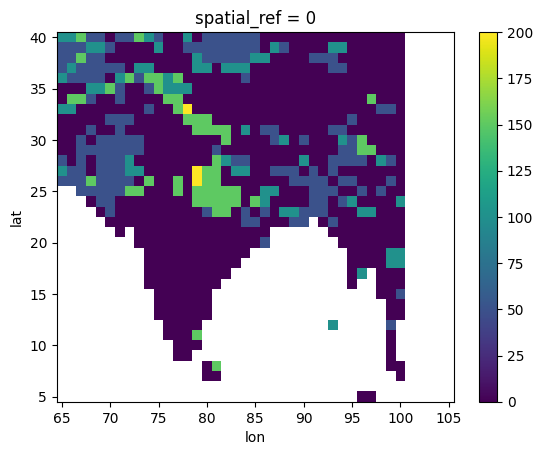

In [16]:
breakpoints.sel(cluster=0).plot()

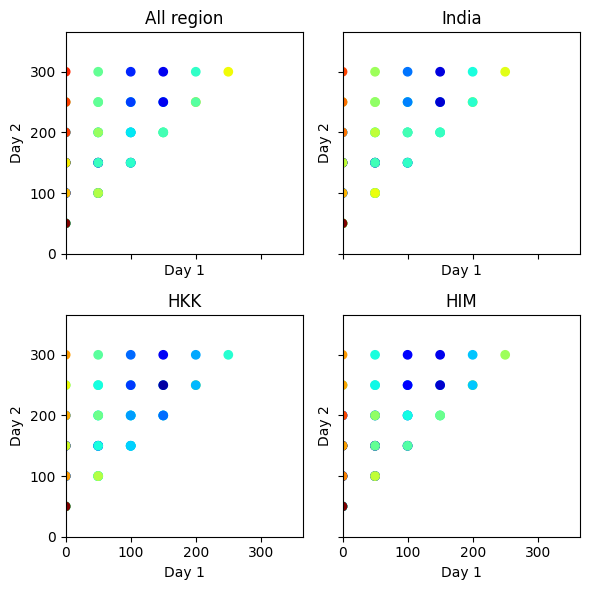

In [17]:
from itertools import combinations

x = np.array(list(combinations(n_days, n_seasons))).squeeze()[:,0]
y = np.array(list(combinations(n_days, n_seasons))).squeeze()[:,1]


# Load country boundary data
error_history_da_clip = error_history_da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
error_history_da_clip.rio.write_crs("epsg:4326", inplace=True)


error_history_da_clip_IND = error_history_da_clip.rio.clip(country_boundary.geometry.apply(mapping), country_boundary.crs, drop=True)
error_history_da_clip_HKK = error_history_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='hkk'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='hkk'].crs, drop=True)
error_history_da_clip_HIM = error_history_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='him'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='him'].crs, drop=True)

z_all = error_history_da_clip.mean(['lat', 'lon']).values
z_IND = error_history_da_clip_IND.mean(['lat', 'lon']).values
z_HKK = error_history_da_clip_HKK.mean(['lat', 'lon']).values
z_HIM = error_history_da_clip_HIM.mean(['lat', 'lon']).values


fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
ax[0][0].scatter(x, y, c=z_all, cmap='jet')
ax[0][0].set_title('All region')
ax[0][0].set_xlabel('Day 1')
ax[0][0].set_ylabel('Day 2')

ax[0][0].set_xlim([0, 365])
ax[0][0].set_ylim([0, 365])

ax[0][1].scatter(x, y, c=z_IND, cmap='jet')
ax[0][1].set_title('India')
ax[0][1].set_xlabel('Day 1')
ax[0][1].set_ylabel('Day 2')

ax[1][0].scatter(x, y, c=z_HKK, cmap='jet')
ax[1][0].set_title('HKK')
ax[1][0].set_xlabel('Day 1')
ax[1][0].set_ylabel('Day 2')

ax[1][1].scatter(x, y, c=z_HIM, cmap='jet')
ax[1][1].set_title('HIM')
ax[1][1].set_xlabel('Day 1')
ax[1][1].set_ylabel('Day 2')

plt.tight_layout()


In [24]:
error_history_da_clip

<xarray.DataArray (lat: 36, lon: 41, iter: 56)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[3327.09155273, 3329.05444336, 3334.85595703, ...,
         3346.86962891, 3376.8527832 , 3379.21069336],
        [3297.73461914, 3305.34960938, 3330.88476562, ...,
         3316.6574707 , 3328.34545898, 3344.9987793 ],
        [3339.59033203, 3317.64257812, 3371.22265625, ...,
         3314.24145508, 3321.47607422, 3343.69311523],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]])
Coordinates:
  * lon          (lon) float64 65.0 66.0 67.0 68.0 ... 102.0 103.0 104.0 105.0
  * lat          (lat) float64 5.0 6.0 7.0 8.0 9.0 ... 36.0 37.0 38.0 39.0 40.0
    spatial_ref  int64 0
Dimensions without coordinates: iter

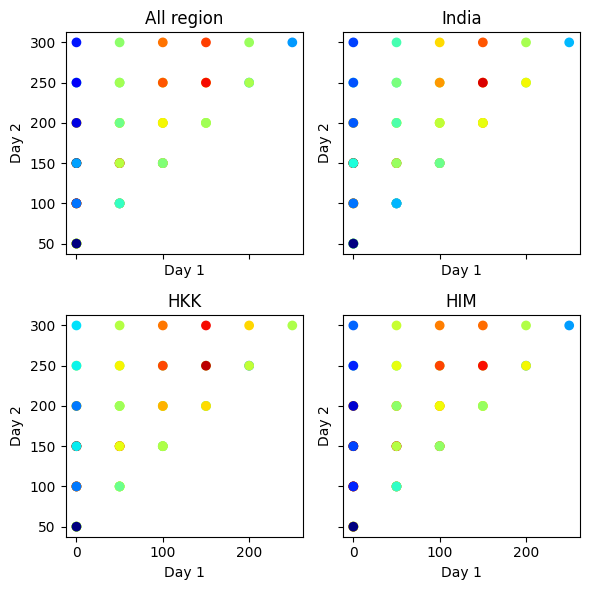

In [18]:
# Load country boundary data
silhouette_scores_da_clip = silhouette_scores_da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
silhouette_scores_da_clip.rio.write_crs("epsg:4326", inplace=True)


silhouette_scores_da_clip_IND = silhouette_scores_da_clip.rio.clip(country_boundary.geometry.apply(mapping), country_boundary.crs, drop=True)
silhouette_scores_da_clip_HKK = silhouette_scores_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='hkk'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='hkk'].crs, drop=True)
silhouette_scores_da_clip_HIM = silhouette_scores_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='him'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='him'].crs, drop=True)

z_all = silhouette_scores_da_clip.mean(['lat', 'lon']).values
z_IND = silhouette_scores_da_clip_IND.mean(['lat', 'lon']).values
z_HKK = silhouette_scores_da_clip_HKK.mean(['lat', 'lon']).values
z_HIM = silhouette_scores_da_clip_HIM.mean(['lat', 'lon']).values


fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
ax[0][0].scatter(x, y, c=z_all, cmap='jet')
ax[0][0].set_title('All region')
ax[0][0].set_xlabel('Day 1')
ax[0][0].set_ylabel('Day 2')

ax[0][1].scatter(x, y, c=z_IND, cmap='jet')
ax[0][1].set_title('India')
ax[0][1].set_xlabel('Day 1')
ax[0][1].set_ylabel('Day 2')

ax[1][0].scatter(x, y, c=z_HKK, cmap='jet')
ax[1][0].set_title('HKK')
ax[1][0].set_xlabel('Day 1')
ax[1][0].set_ylabel('Day 2')

ax[1][1].scatter(x, y, c=z_HIM, cmap='jet')
ax[1][1].set_title('HIM')
ax[1][1].set_xlabel('Day 1')
ax[1][1].set_ylabel('Day 2')

plt.tight_layout()


In [33]:
x = np.array(list(combinations(n_days, n_seasons))).squeeze()[:,0]
y = np.array(list(combinations(n_days, n_seasons))).squeeze()[:,1]
z = np.array(list(combinations(n_days, n_seasons))).squeeze()[:,2]

array([0.07843808, 0.08497234, 0.08227421, 0.087638  , 0.08812083,
       0.05981129, 0.08261592, 0.09011536, 0.10014068, 0.10077525,
       0.07041716, 0.08580691, 0.10385097, 0.10366224, 0.07221248,
       0.08894794, 0.09027814, 0.06367596, 0.07850003, 0.06458109,
       0.06628564, 0.06639804, 0.07329019, 0.08426452, 0.08834707,
       0.07787956, 0.07477552, 0.09416054, 0.09740675, 0.08505682,
       0.08397025, 0.08871241, 0.08102716, 0.07932614, 0.08402381,
       0.08285137, 0.06422253, 0.08400075, 0.08884627, 0.08217133,
       0.08435998, 0.09055505, 0.08835975, 0.08574286, 0.09593661,
       0.09456131, 0.08341806, 0.08598446, 0.08384026, 0.08863978,
       0.09929097, 0.09695571, 0.07408091, 0.08429458, 0.08339517,
       0.07197522])

In [36]:
np.array(list(combinations(n_days, n_seasons))).squeeze()[0]

array([  0,  50, 100])

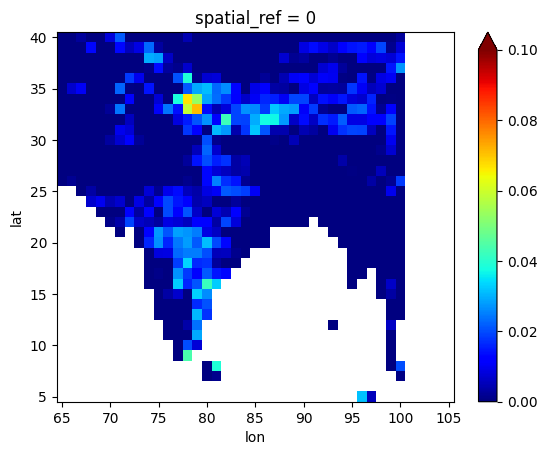

In [38]:
(silhouette_scores_da.isel(iter = -1) - silhouette_scores_da.isel(iter = 0)).plot(vmin=0, vmax=0.1, extend='max', cmap='jet')

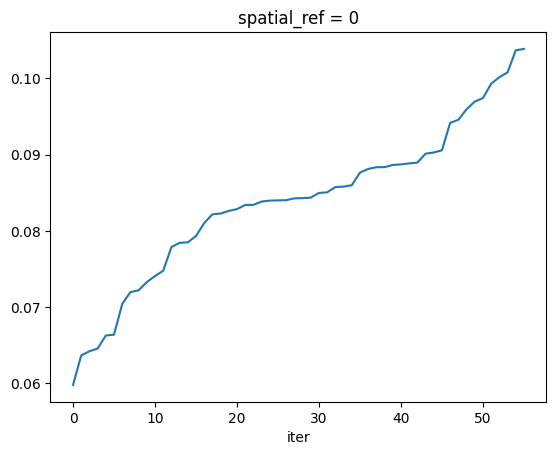

In [39]:
a = silhouette_scores_da.mean(['lat','lon'])#.plot(hue='lon', add_legend=False)

# sort a by value
a = a.sortby(a).plot(hue='lon', add_legend=False)
a

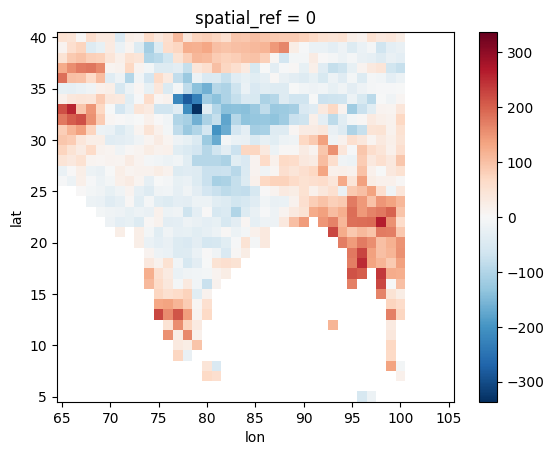

In [40]:
(error_history_da.isel(iter = -1) - error_history_da.isel(iter = 0)).plot()

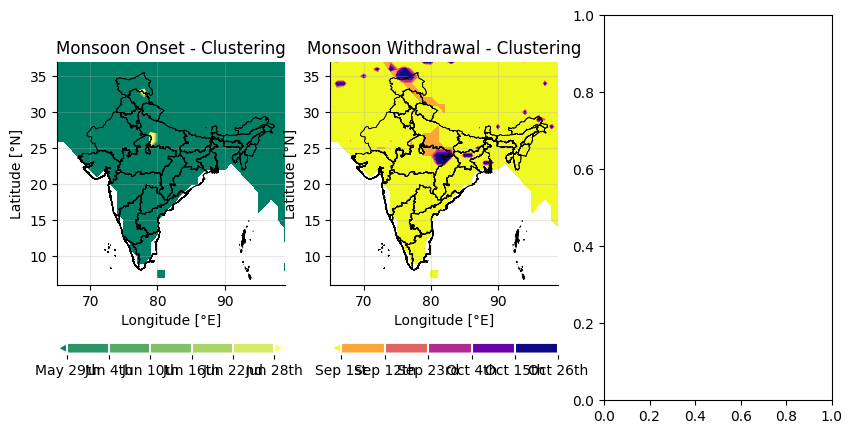

In [22]:
# Load country boundary data
# mask_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')
# mask_boundary = mask_boundary[mask_boundary["GID_0"].isin(['IND','NPL','BGD'])]

# result_plot = result.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
# result_plot.rio.write_crs("epsg:4326", inplace=True)
# result_plot = result_plot.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)

result_plot = breakpoints


plot_seasons_bk_results( result_plot, figsize=(10,5), cmaps=['summer', 'plasma_r'],
                         lims=[[150,180],[245,300]], titles=['Monsoon Onset - Clustering', 'Monsoon Withdrawal - Clustering'],
                         country_boundary=country_boundary, world_boundary=country_boundary)

# plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

In [23]:
# if not os.path.exists(results_path_file) or overwrite_results:
    
#     result.attrs=dict(
#             Description="Dataset with seasonal onset dates obtained with Radially Constrained Clustering",
#             Parameters=(

#                 f"Number of seasons: {n_seasons}",
#                 f"Number of iterations: {n_iters}",
#                 f"Learning rate: {learning_rate}",
#                 f"Minimum length of seasons: {min_len}",
#                 f"Clustering mode: {mode}",
#                 f"Initializtion dates: {[day_of_year_to_date(x) for x in starting_bp]}",
        
#             )
#         )

#     result.to_netcdf(results_path_file)